# Geothermal Feasibility Study



### Sketch

<img src="roofdiagram.jpg" alt="my awesome sketch"  width=50%>

### Objective 
The objective of the final heat transfer project was to create computational models to study the feasibility and energy cost of using geothermal to supplement the cooling thermal management of a building. The building is assumed to be a currently standing building, with steel decking insulation and neglecting wall loads. The model was created with the following assumptions:

### Assumptions
-Ground was assumed to be at 10C at 2m deep
-Soil was assumed to be clay
For the heat exchange between soil and piping, two possibilities were examined:

-Option 1: The outside surface is at soil temperature in the heat exchanger

-Option 2: Introduced a parametric distance at which the soil was at 10C from the surface of the pipe. Studied the effect of that distance on the pipe length

-Recommended material for piping was assumed to be HDPE

-Thermal conductivity of HDPE =	0.35 - 0.49 	W / mK
#Cost of HDPE Pipe: 
#Pipe Roughness: : 0.00006

The heat exchanger is assumed to require cool temperature of 12C and return temperature of 22C. Heat exchanger efficacy is estimated at 0.75

Indoor temperature of 20C is assumed

Properties of the pipe were acquired from 

https://hdpesupply.com/1-ips-sdr11-pe4710-black-hdpe-pipe-500-coil/ : \\$0.82 per foot OR \\$2.69 per meter



In [1]:
import sys  
sys.path.insert(0, 'Libraries/') 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
xl = pd.ExcelFile('Climate/Burlington, VT 2021-01-01 to 2021-12-31.xlsx')

In [3]:
weather = pd.read_excel("Climate/Burlington, VT 2021-01-01 to 2021-12-31.xlsx",
                        sheet_name=xl.sheet_names[0],header=0,
                        converters= {'datetime': pd.to_datetime},)
weather = weather.set_index('datetime')
weather.head(1) 

,name,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-01,"Burlington, VT",-3.9,-7.7,-8.8,68.6,0.0,NaN,NaN,0.0,6.3,...,1030.1,48.8,16.0,NaN,NaN,NaN,NaN,Partially cloudy,partly-cloudy-night,"72622564776,KPBG,KBTV,KMVL,72611454771,7261701..."


In [4]:
weather.columns

Index(['name', 'temp', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'preciptype', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex', 'severerisk', 'conditions', 'icon',
       'stations'],
      dtype='object')

In [5]:
interp_method = 'linear' 
weather['solarradiation'] = weather['solarradiation'].fillna(0.0)
weather['cloudcover'] = weather['cloudcover'].fillna(0.0)
weather['precip'] = weather['precip'].fillna(0.0)
weather['windspeed'] = weather['windspeed'].interpolate(interp_method)
weather['temp'] = weather['temp'].interpolate(interp_method)
weather['solarradiation'] = weather['solarradiation'].interpolate(interp_method)
weather['cloudcover'] = weather['cloudcover'].interpolate(interp_method)
weather['dew'] = weather['dew'].interpolate(interp_method)
weather['precip'] = weather['precip'].interpolate(interp_method)
weather['humidity'] = weather['humidity'].interpolate(interp_method)

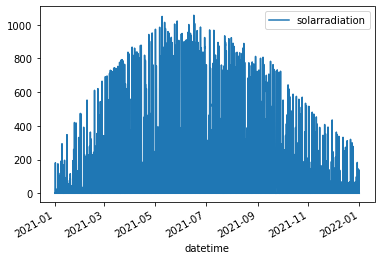

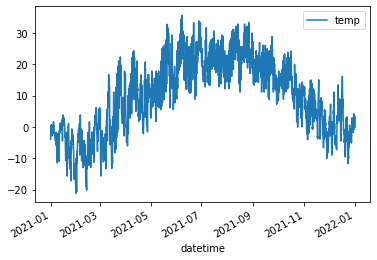

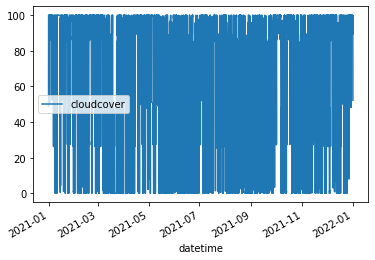

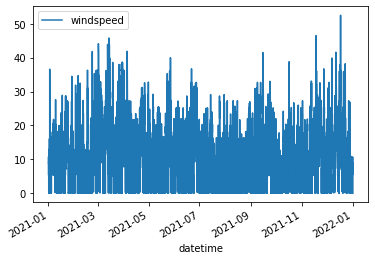

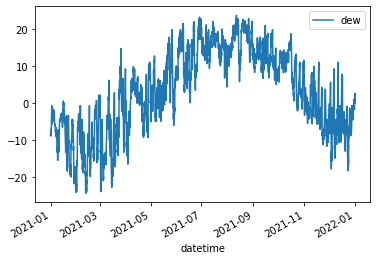

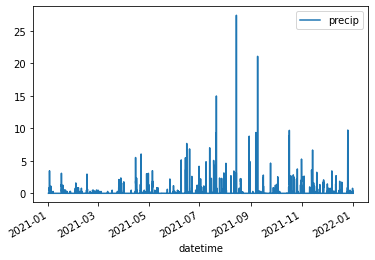

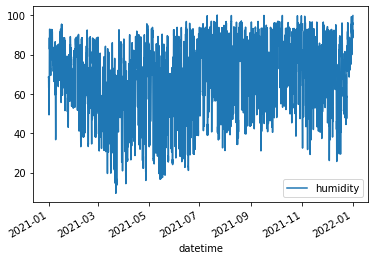

In [6]:
ax0 = weather.plot(y='solarradiation')
ax0 = weather.plot(y='temp')
ax0 = weather.plot(y='cloudcover')
ax0 = weather.plot(y='windspeed')
ax0 = weather.plot(y='dew')
ax0 = weather.plot(y='precip')
ax0 = weather.plot(y='humidity')

In [7]:
from scipy.interpolate import interp1d
interp_method = 'cubic'

t_data = np.arange(0,weather.shape[0]*15*60,15*60)
U_atm = np.abs(weather['windspeed'][:].to_numpy()/3.6) #converted from km/h to m/s
T_atm = weather['temp'][:].to_numpy()
q_sun = weather['solarradiation'][:].to_numpy()
# CC = weather['Cloud Cover'][:].to_numpy()
cc = weather['cloudcover'][:].to_numpy()/100. # converted from % to fraction
rh = weather['humidity'][:].to_numpy() # left as %
p_r = weather['precip'][:].to_numpy()*1e-3/(15*60) #converted to mm to m/s 
T_dp = weather['dew'][:].to_numpy()
f_U_atm = interp1d(t_data,U_atm,kind=interp_method)
def U_atmospheric(t):
    global f_U_atm
    return np.maximum(f_U_atm(t),0.)
f_T_atm = interp1d(t_data,T_atm,kind=interp_method)
def T_atmospheric(t):
    global f_T_atm
    return f_T_atm(t)
f_q_sun = interp1d(t_data,q_sun,kind=interp_method)
def sun_irradiation(t):
    global f_q_sun
    return np.maximum(f_q_sun(t),0.)
f_CC = interp1d(t_data,cc,kind=interp_method)
def cloud_cover(t):
    global f_CC
    return np.clip(f_CC(t),0.,1.)
f_T_dp = interp1d(t_data,T_dp,kind=interp_method)
def dew_point(t):
    global f_T_dp
    return f_T_dp(t)
f_RH = interp1d(t_data,rh,kind=interp_method)
def relative_humidity(t):
    global f_RH
    return np.clip(f_RH(t),0.,100.)
f_rain = interp1d(t_data,p_r,kind=interp_method)
def rain_rate(t):
    global f_rain
    return np.maximum(f_rain(t),0.)


### Importing Heat Transfer Libraries

In [8]:
import scipy.constants as csts
from scipy.integrate import solve_ivp
from Libraries import thermodynamics as thermo
from Libraries import HT_external_convection as extconv
from Libraries import HT_natural_convection as natconv

### Convection heat transfer on upper surface

Convection heat transfer is determined by the relative strength of forced and natural convection. Here the forced convection is the wind over the roof. Regardless of the direction of the wind, the length of the slab is always assumed to be the dimension of the square making the roof $L$. Thermodynamics properties with a subscript $f$ denotes properties evaluated at the film temperature
$$
T_f = \frac{T_s+T_\infty}{2}\,,
$$ where $T_s$ is the temperature at the surface of the slab. For every time iteration, the following non-dimensional numbers are computed:
* Reynolds number quantifies the wind strength
$$
Re=\frac{U_\infty L}{\nu_f}
$$
* Grashoff number quantifies the natural convection strength
$$
Gr=\frac{g\beta\left\vert T_s-T_\infty\right\vert L^3}{\nu_f^2}
$$
* Richardson number quantifies the relative strength of natural convection vs forced wind convection
$$
Ri=\frac{Gr}{Re^2}
$$
* Rayleigh number is required for Nusselt number convection in case of natural convection.
$$
Ra=\frac{g\beta\left\vert T_s-T_\infty\right\vert L^3}{\nu_f\alpha_f}
$$

The following algorithm determines the local average convection coefficient
$$
\bar{h}=\bar{h}_{forced}+\bar{h}_natural=\frac{\overline{Nu}_{forced}k_f}{L}+\frac{\overline{Nu}_{natural}k_f}{L}
$$
where $\overline{Nu}_{forced}$ is the correlation for the flow over a plate at constant temperature and $\overline{Nu}_{natural}$ is the correlation for natural convection over a horizontal surface at constant temperature. 

* If the wind velocity drops below $U_\infty=0.15\mathrm{m/s}$, there is no forced convection: $h_{forced}=0$
* If $Ri<0.1$, natural convection is negligible, $h_{natural} = 0$, compute $h_{forced}$
* If $Ri>10$, forced convection is negligible, $h_{forced}=0$, compute $h_{natural}$
* If $0.1\leq Ri\leq 10$ compute both $h_{forced}$ and $h_{natural}$

In [9]:
def outsideconvection(Uinf,T_f,Tinf,air_f,Lroof,Ts):
    #yourcodehear
    A = 100
    g = 9.81
    Ra = natconv.Ra(beta=air_f.beta,DT=np.abs(Ts-Tinf),D=Lroof,nu=air_f.nu,alpha=air_f.alpha)

    if Uinf < 0.15:
        Ri=11
    else:
        Gr = g*air_f.beta*(Ts - Tinf)*Lroof**3/(air_f.nu**2)
        Re = Uinf*Lroof/air_f.nu
        Ri = Gr/Re**2
    
    if Ri < 0.1:
        #natural convection is negligible: Forced Convection
        air_bl = extconv.FlatPlate('mixed','isothermal',Uinf,air_f.nu,air_f.alpha,Lroof,xi=0,Re_xc=5e5)
        air_bl.average(Lroof)
        Nu_ave = air_bl.Nu_ave

        h_forced = (Nu_ave*air_f.k)/Lroof
        h_nat = 0
               
    elif 0.1 <= Ri and Ri <= 10:
        #Mixed Regime 
        air_bl = extconv.FlatPlate('mixed','isothermal',Uinf,air_f.nu,air_f.alpha,Lroof,xi=0,Re_xc=5e5)
        air_bl.average(Lroof)
        Nu_ave = air_bl.Nu_ave
        kf = air_f.k 
        h_forced = (Nu_ave*air_f.k)/Lroof
        if Ts >= Tinf:
            airFlow = natconv.FlatPlate(Ra,air_f.Pr,'upper','hot')
        else:
            airFlow = natconv.FlatPlate(Ra,air_f.Pr,'upper','cold')
        h_nat = airFlow.Nu*air_f.k/Lroof
            
    elif Ri > 10:
        #forced convection is negligible: Natural Convection
        if Ts >= Tinf:
            airFlow = natconv.FlatPlate(Ra,air_f.Pr,'upper','hot')
        else:
            airFlow = natconv.FlatPlate(Ra,air_f.Pr,'upper','cold')
        h_nat = airFlow.Nu*air_f.k/Lroof
        h_forced = 0
    
    h = h_nat + h_forced
    qpp = h*(Tinf - Ts)
    return qpp

### Radiation between outer surface and sky

The radiation between the surface and sky depends on cloud coverage (variable $cc$ between 0 and 1), air temperature and the dew point temperature $T_{dp}$ for the correlation chosen below. 

#### Definition of $T_{sky}$
* $T_{\infty}$ Air temperature $\mathrm{^\circ C}$
* $T_{dp}$ Dew point temperature $\mathrm{^\circ C}$
* $cc$ Cloud coverage
* $\varepsilon_{clear}$: emissivity of clear blue sky
* $\varepsilon_{sky}=1$

$$
\varepsilon_{clear}=0.711 + 0.56\frac{Tdp}{100} + 0.73\left(\frac{Tdp}{100}\right)^2
$$

$$
Ca = 1. + 0.02224cc + 0.0035cc^2 + 0.00028cc^3
$$

$$
T_{sky}  = (Ca\varepsilon_{clear})^{0.25}(Tinf+273.15)
$$

#### Radiation coefficient between surface and sky
$$
h_{rad,sky}= \varepsilon_{sky}\sigma((T_{sky}+273.15)+(T_s+273.15))
        ((T_{sky}+273.15)^2+(T_s+273.15)^2)
$$

In [10]:
def T_sky(Tdp,cc,Tinf,Ts):
    eps_clear = 0.711 + 0.56*(Tdp/100.) + 0.73*(Tdp/100.)**2
    Ca = 1. + 0.02224*cc + 0.0035*cc**2 + 0.00028*cc**3
    Tsky  = (Ca*eps_clear)**0.25*thermo.C2K(Tinf)
    hr = eps_sky*csts.sigma*(Tsky+thermo.C2K(Ts))* \
        (Tsky**2+thermo.C2K(Ts)**2)
    return Tsky,hr
def skyradiation(Tdp,cc,Tinf,Ts):
    # Ts must be in Celsius
    Tsky,hr = T_sky(Tdp,cc,Tinf,Ts)
    qsky = eps_sky*csts.sigma*(Tsky**4 - thermo.C2K(Ts)**4)
    return qsky


### Heat transfer with rain

Rain has a cooling or heating effect on the surface depending on the difference between the wet bulb temperature and the surface temperature. The wet bulb temperature is a function of air temperature and humidity. The heat flux of the rain onto the surface is then calculated as the difference of the rate of enthalpy of the rain at wet bulb temperature hitting the surface and the rate of enthalpy at surface temperature for the same flow rate (variable $Pr$ for precipitation).
#### Wet Bulb Temperature Correlation

$$
T_{WB}=T_\infty\arctan\left[0.1515977\sqrt{RH + 8.313659}\right] + \arctan(T_\infty + RH) - \arctan(RH - 1.676331) + 0.00391838RH^{1.5}\arctan(0.023101RH) \
            - 4.686035
$$

#### Heat Flux of Cooling by Rain
$$
q''=\rho C_p P_r(T_{WB}-Ts(t))
$$

where $\rho=1000\mathrm{kg/m^3}$, $C_p=4.19\times10^3\mathrm{J/Kg.K}$ and $P_r$ is the precipitation.


In [11]:
def T_wet_bulb(T,RH):
    return T * np.arctan(0.1515977*(RH + 8.313659)**0.5) + np.arctan(T + RH) \
            - np.arctan(RH - 1.676331) + 0.00391838*RH**1.5*np.arctan(0.023101*RH) \
            - 4.686035
def rain(pr,Tinf,RH,Ts):
    Twb = T_wet_bulb(Tinf,RH)
#     print("rain",pr,Twb,Tinf,RH,Ts)
    rho = 1000.
    Cp = 4.19e3
    return rho*Cp*pr*(Twb - Ts)
    

### Conduction Through Roof -Flat

In [12]:
def roof_cond(k_ins,k_steel,H_ins,H_steel,Ts_lower,Ts):
    Rcondroof=(H_ins/k_ins+H_steel/k_steel) #Assumes flat top
    qpp=(1/Rcondroof)*(Ts-Ts_lower)
    return qpp

## Governing equation of the system

Conservation of energy equation is applied to the outer surface of the slab, which is assumed to be at uniform temperature $T_s(t)$:

$$
\iint_A\rho_{ins}C_{p,ins}\frac{dT_s}{dt}\rho_{ins}C_{p,ins}A\frac{dT_s}{dt}=q_{sun}+q_{rain}+q_{conv}+q_{rad,sky}-q_{cond}=(q''_{sun}+q''_{rain}+q''_{conv}+q''_{rad,sky}-q''_{cond})A
$$

Therefore the equation govering the surface temperature is:
$$
\frac{dT_s}{dt}=\frac{1}{\rho_{ins}C_{p,ins}}(q''_{sun}+q''_{rain}+q''_{conv}+q''_{rad,sky}-q''_{cond})\;\;\;\;\;\mathrm{Eq.\;(1)}
$$

The cooling demand fluctuates over time:

$$
q''_{cool}(t)=\begin{cases}
\frac{1}{R''_{tot}}(T_s(t)-T_{s,lower}) &\text{if }T_s(t)\geq T_{s,lower}\\
0 & \text{otherwise}
\end{cases}
$$
where $R''_{tot}=R''_{cond,ins}+R''_{cond,concrete}$.

Note that the irradiation from the sun is only partly absorbed by the surface:
$$
q''_{sun}=\alpha_{abs}I_{sun}(t)\;,
$$
where $\alpha_{abs}$ is the surface absorptivity ($0\leq \alpha_{abs}\leq 1$, always) and $I_{sun}(t)$ is the measure irradiation from the sun.

In [13]:
def f(t,T):
    global Lroof,k,H,eps,f_U_atm,f_T_atm,f_q_sun,rho,C_p,alpha_s,f_CC,f_T_dp
    # film temperature between ambient and upper surface
    Tinf = T_atmospheric(t)
    Uinf = U_atmospheric(t)
    
    T_f = (T[0]+Tinf)/2
    air_f = thermo.Fluid('air',T_f,"C")
    Tdp = dew_point(t)
    cc = cloud_cover(t)
    pr = rain_rate(t)
    rh = relative_humidity(t)
    
    
    qpp_sun = alpha_s*sun_irradiation(t)
    
    qpp_sky = skyradiation(Tdp,cc,Tinf,T[0])
    
    qpp_conv = outsideconvection(Uinf,T_f,Tinf,air_f,Lroof,T[0])
    
    qpp_rain = rain(pr,Tinf,rh,T[0])
    
    qpp_cond = roof_cond(k_ins,k_steel,H_ins,H_steel,Ts_lower,T[0])
    
    qpp_total = qpp_sun + qpp_sky + qpp_conv + qpp_rain - qpp_cond
    
    return qpp_total/(rho*C_p)
    

## Main code

In [14]:
rho = 20.
C_p = 2500.
alpha_s = 0.5
eps_sky = 1.

#Inputs
k_ins = 0.04 #W/(mK)
H_ins = 0.0508 #m
k_steel = 0.046 #W/(mK)
H_steel = 0.0009525 #m
Lroof = 100
A = Lroof**2
Ts_lower = 20 #C

tmax = t_data[-1]
mask = np.where(t_data <= tmax)
sol = solve_ivp(f,[0,tmax],[-5],method='LSODA',t_eval=t_data[mask],max_step=10*60.)

### Maximum Cooling Load

In [15]:
weather['Tsu'] = sol.y[0]
Rcondroof=(H_ins/k_ins+H_steel/k_steel)
weather['q_cool'] = np.maximum((1/Rcondroof)*(sol.y[0] - Ts_lower)*A,0.)

#Input
#q_HUMANITY=100*4035 

print("Maximum cooling demand: %.0f W" %(weather['q_cool'].max()))
print("on %s " %weather.index[weather['q_cool'].argmax()].strftime("%m/%d/%Y, %H:%M:%S"))


Maximum cooling demand: 214275 W
on 06/07/2021, 16:00:00 


In [16]:
q_Geo=((weather['q_cool'].max())/.75)
print("With a 75 percent efficient heat exchanged, the geothermal cooling system must supply %.0f W" %q_Geo)

With a 75 percent efficient heat exchanged, the geothermal cooling system must supply 285700 W


## Piping length inside the geothermal system

We consider a close loop system containing water which should arrive at the heat exchanger with a temperature of C and exits the heat exchanger at 12C. Assuming that these temperatures to be the temperatures at the entrance of the underground pipe (20C) and the exit (12C), the heat transfer between the geothermal system and the water circulating in a pipe is:

$$
q=\dot{m}C_p(T_{m,i}-T_{m,o})\;\;\;\;\;\mathrm{Eq\;(3)}
$$
where $\dot{m}$ is the mass flow rate.

Eq. (3) is used to determine the flow rate, which in turn defines the convection coefficient of the flow within the pipe using the Dittus Boettler correlation. 

Assuming that the outside surface of the pipe is at $\mathrm{12^\circ C}$, the total resistance between the flow and the ground per unit length is

$$
R'_{tot}=R'_{conv,i}+R'_{cond}
$$

$L$ is then the solution of the equation for the variation of temperature between inlet and outlet of the pipe

$$
\frac{T_\infty-T_{m,o}}{T_\infty-T_{m,i}}=\exp\left(-\frac{1}{\dot{m}C_pR_\text{tot}}\right)
$$
for the target outlet temperature $T_{m,o}$. First, assuming 1D, steady convection on the outside of the pipe, we must solve for $R'_{tot}$. Since
$$
R_{tot}=\frac{R'_{tot}}{L}
$$
the pipe length is
$$
L=-\dot{m}C_pR'_\text{tot}\ln\frac{T_\infty-T_{m,o}}{T_\infty-T_{m,i}}
$$

Here we assume that the analysis for a straight pipe applies to a system where the pipe will most likely spiral within the ground.

In [36]:
Tmi = 22. #C
Tmo = 12. #C
#qcool_max = 285700. #W
Delta_T = Tmo - Tmi
Tm = (Tmo + Tmi)/2
water_Tm = thermo.Fluid('water',Tm,"C")
mdot = q_Geo/(water_Tm.Cp*abs(Delta_T))
print("mass flow rate: %.4f kg/s" %mdot)
Di = 4*0.0254
Do = Di + 0.3*0.0254
kpipe = 2.25
A = np.pi*Di**2/4
Um = mdot/(water_Tm.rho*A)
print("Average velocity: %.3f m/s" %Um)

import HT_thermal_resistance as res
import HT_internal_convection as intconv
Rp = []
Rp.append(res.Resistance("$R'_{conv,i}$", "W/m"))
Rp.append(res.Resistance("$R'_{cond}$", "W/m"))
pipeflow = intconv.PipeFlow(D=Di,L=1,Um=Um,nu=water_Tm.nu)
print("Re_D_pipe= %.0f" %pipeflow.Re)
pipeflow.Dittus_Boelter(mode='cooling',Pr=water_Tm.Pr)
hint = pipeflow.Nu*water_Tm.k/Di
print("h_int=%.1f W/m^2.K" %hint)
Rp[0].convection(h=hint,A=np.pi*Di)

# conduction
Rp[1].cond_cylinder(k=kpipe,ra=Di,rb=Do,L=1.)
Rptot = Rp[0].R + Rp[1].R
T_infty=10.
L = intconv.L_given_other_params(T_infty,Tmo,Tmi,mdot,water_Tm.Cp,Rptot)
print("The necessary length of the pipe is %.0f m" %L)

mass flow rate: 6.8244 kg/s
Average velocity: 0.843 m/s
Re_D_pipe= 79194
h_int=2048.9 W/m^2.K
The necessary length of the pipe is 340 m


### Pipe Headloss, Required Power, and Cost

A uniform flow entering a pipe first experiences streamwise variation of velocity to accommodate the wall boundary conditions. A boundary layer, of thickness $\delta$, forms on the wall and grows until its edge reaches the pipe centerline. This region is the hydrodynamic entrance region. Beyond that point, the flow becomes fully developed, which means that
<ul>
<li> In the laminar regime, the velocity profile is only a function of $r$,</li>
<li> In the turbulent regime, the <b>mean</b> velocity profile is only a function of $r$.</li>
</ul>
Friction drag or the force exerted by the flow onto the pipe wall governs the pressure gradient necessary to generate a desired flowrate. Calculation of the friction drag leads to the design of the mechanical force creating the pressure gradient. In fully developed (laminar or turbulent) regimes, the pressure gradient may be determined by
<p class='alert alert-danger'>
$$
-\frac{\Delta\overline{P}}{L}=f\,\frac{1}{D}\,\frac{\rho U_m^2}{2}\;\;\;\;
$$
</p>
where $D=2R$ and $L$ are the diameter and length of the pipe, respectively, and $f$ is the <b>friction factor</b>. The bulk velocity or average velocity is
<p class='alert alert-info'>
$$
U_m=\frac{\dot{m}}{\rho A_c}\;\;\;\;
$$
Where $A_c$ is the cross sectional area of the pipe.
</p>
where $\dot{m}$ is the mass flux
$$
\dot{m}=\int_0^{2\pi}\int_0^R\rho \overline{u}(r)\,r\,dr d\theta=2\pi\int_0^R\rho \overline{u}(r)\,r\,dr\;\;\;\;
$$
and $A_c=\pi R^2$
The Reynolds number of the flow is based on the bulk velocity and pipe diameter:
<p class='alert alert-danger'>
$$
Re_D=\frac{\rho U_mD}{\mu}=\frac{4\dot{m}}{\pi D\mu}\;\;\;\;
$$
</p>

Beyond the critical Reynolds number, $f$ is a function of the roughness to diameter ratio $\varepsilon=e/D$ (e is typically the standard deviation of the roughness height) and the Reynolds number.
<p class='alert alert-danger'>
$$
\frac{1}{\sqrt{f}}=-2\log_{10}\left[\frac{\varepsilon}{3.7}+\frac{2.51}{Re_D\sqrt{f}}\right]\;\;\;\;
$$
</p>

Often there is a need to determine the pump or blower power $P$ necessary to move the flow at a prescribed pressure drop:
<p class='alert alert-danger'>
$$
P=\frac{\dot{m}}{\rho}\Delta p= \underbrace{(\Delta p)A_c}_\text{force}\cdot U_m\;\;\;\;
$$
</p>


Here we assume that the analysis for a straight pipe applies to a system where the pipe will most likely spiral within the ground.

## Pipe Cost

Taking the pipe cost to be $11.88 per meter of pipe based on an online source (https://hdpesupply.com/4-ips-sdr17-pe4710-black-hdpe-pipe-straight-length-per-foot/), the cost of the pipe is simply calculated by multiplying that cost by the length of the pipe found in meters.

$$
Cost_{Pipe}=Length*$11.88
$$

In [35]:
from Libraries import thermodynamics as thermo
waterflow = thermo.Fluid('water',Tm,"C")
#Importing thermo libraries

#Setting fluid temperature for properties (Set as average temp T_in+T_out/2)
#Setting up opbject for water flow

g = 9.8
#Gravity Constant
#Length of pipe
#Diameter of pipe
#Velocity of flow in pipe
Cost_Per_Meter = 11.88 #$/m
#Cost Per Meter of Pipe - https://hdpesupply.com/4-ips-sdr17-pe4710-black-hdpe-pipe-straight-length-per-foot/
Pipe_Cost_Tot = L*Cost_Per_Meter
#Total cost for pipe
vdot = mdot/1000 #(m^3/s)
#Volume Flow Rate 
P_eff = 0.85
#Efficiency of Pump


pipe = intconv.PipeFlow(D=Di, L=L, rho=waterflow.rho, nu=waterflow.nu, Um=Um)

print("Total cost of pipe = $%1.0f" %Pipe_Cost_Tot)
print("Kinematic viscosity : %0.2e m^2/s" %waterflow.nu)
print("Re= %1.2e" %pipe.Re)
print("Mass flowrate= %1.1f kg/s" %mdot)
print("Volume flowrate= %1.3f m^3/s" %vdot)
pipe.f_turbulent(eps=0.03)
print("Friction Factor = %1.5f" %pipe.f)
h_lf = pipe.f*L/Di*(Um*Um)/(2*g)
print('Head Loss Due to Friction = %.2f m' %h_lf)

print("Pressure Gradient -dP/dx= %1.0f Pa/m" %pipe.dPdx)


P_power = (pipe.mdot/waterflow.rho)*pipe.dPdx
print("Pumping Power Required = %1.0f Watts" %P_power)
P_spec = (1/0.85)*P_power
#Power Spec of Pump
print("Pump Power Spec With a Pump Efficiency of %1.2f is %1.0f Watts" %(P_eff,P_spec))

Total cost of pipe = $4041
Kinematic viscosity : 1.08e-06 m^2/s
Re= 7.92e+04
Mass flowrate= 6.8 kg/s
Volume flowrate= 0.007 m^3/s
Friction Factor = 0.05750
Head Loss Due to Friction = 6.98 m
Pressure Gradient -dP/dx= 68279 Pa/m
Pumping Power Required = 467 Watts
Pump Power Spec With a Pump Efficiency of 0.85 is 549 Watts


#### Why does the room model need three temperatures?



*`T[0]` : Temperature of the roof exposed to the outside. This discribes the boundary conditions for the energy entering the control surface



*`T[1]` : Temperature of the ceiling. this defines the interior control surface exposed to the volume of the room.



*`T[2]` : Average temperature of the room



*`T[3]` : is NOT a temperature, it is a coefficient equal to 1 when heating is needed, -1 when cooling is needed, 0 when `T[2]` is between $T_{sp}-\Delta_{sp}$ and $T_{sp}+\Delta_{sp}$



The code solves four equations



$$
\frac{dT_i}{dt}=\frac{1}{\rho C_p}(\sum E_{in}-\sum E_{out}+ \sum E_g)
$$
for i=0,1,2,3

### Inside Convection

In [19]:
def insideconvection(T_f_in, T_vol, air_f_in, Lplate, T_surf):
    Ra = natconv.Ra(beta=air_f_in.beta,DT=np.abs(T_surf-T_vol),D=Lplate,nu=air_f_in.nu,alpha=air_f_in.alpha)
    
    #No forced convection inside
    NaturalConvection = True
    
    #Natural convection flux
    if NaturalConvection and Ra > 1e4:
        if T_surf >= T_vol:
            airflow = natconv.FlatPlate(Ra,air_f_in.Pr,'upper','hot')
        else:
            airflow = natconv.FlatPlate(Ra,air_f_in.Pr,'upper','cold')
        hconv_n = airflow.Nu*air_f_in.k/Lplate
    else:
        hconv_n = 0
    h = hconv_n
    qpp = h*(T_surf - T_vol)
    
    return qpp

### Variable Input

In [20]:
T_hvac = 4*60 #4mins in seconds 
q_hvac = 10000 #W, power delivered by the hvac
V_room = 100*100*5

T_sp = 20
DT_sp = 1

### Updated Building Model Code

In [21]:
#Code for building:

def f_room(t,T):
    global Lroof,eps,f_U_atm,f_T_atm,f_q_sun,rho,C_p,alpha_s,f_CC,f_T_dp,T_sp,DT_sp
    global q_hvac,T_hvac,V_room
    dTdt = np.zeros(len(T))
    # film temperature between ambient and upper surface
    Tinf = T_atmospheric(t)
    Uinf = U_atmospheric(t)
    
    T_f = (T[0]+Tinf)/2
    air_f = thermo.Fluid('air',T_f,"C")
    Tdp = dew_point(t)
    cc = cloud_cover(t)
    pr = rain_rate(t)
    rh = relative_humidity(t)
    
    #input number of people
    #q_HUMANITY=(100*4035)
    
    qpp_sun = alpha_s*sun_irradiation(t)
    
    qpp_sky = skyradiation(Tdp,cc,Tinf,T[0]) #h_rad(T_s - T_sky)
    
    qpp_conv = outsideconvection(Uinf, T_f,Tinf, air_f,Lroof, T[0]) #h_conv_tot(T_s -T_inf)
    
    qpp_rain = rain(pr,Tinf,rh,T[0]) #h_rain(Twb - T_s)
    
    qpp_cond = roof_cond(k_ins,k_steel,H_ins,H_steel,T[1],T[0])
    
    T_f_in = (T[1] + T[2])/2.
    air_f_in = thermo.Fluid('air',T_f_in,"C")
    qpp_conv_in = insideconvection(T_f_in, T[2], air_f_in, Lroof, T[1])
    qpp_total = qpp_sun + qpp_sky + qpp_conv + qpp_rain - qpp_cond
    dTdt[0] = qpp_total/(rho*C_p)
    dTdt[1] = (qpp_cond - qpp_conv_in)/(air_f_in.rho*air_f_in.Cp)
    air_room = thermo.Fluid('air',T[2],"C")

 

    dTdt[2] = (qpp_conv_in*A + T[3]*q_hvac)/(air_room.rho*air_room.Cp*V_room)
    if T[2] > T_sp + DT_sp:
        if T[3] >= -1:
            dTdt[3] = -1./T_hvac
    elif T[2] < T_sp - DT_sp:
        if T[3] <= 1.:
            dTdt[3] = 1./T_hvac
    return dTdt



### Updated Model Main Code

In [22]:
rho = 20.
C_p = 2500.
alpha_s = 0.5
eps_sky = 1.

#Inputs
k_ins = 0.04 #W/(mK)
H_ins = 0.0508 #m
k_steel = 0.046 #W/(mK)
H_steel = 0.0009525 #m
Lroof = 100
A = Lroof**2
Ts_lower = 20 #C

tmax = t_data[-1]
mask = np.where(t_data <= tmax)

sol = solve_ivp(f_room,[0,tmax],[f_T_atm(t_data[0]),T_sp,T_sp,0],method='LSODA',t_eval=t_data[mask],max_step=600)

### Cooling Load Comparison

In [23]:
weather['q_hvac_cooling']=-np.clip(sol.y[3],-1.1,0.)*q_hvac

<AxesSubplot:xlabel='datetime'>

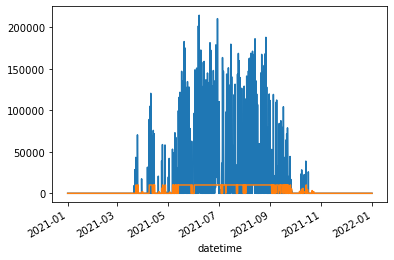

In [24]:
wombat=weather['q_cool'].plot()
weather['q_hvac_cooling'].plot(ax=wombat)

In [25]:
weather['q_cool'].sum()*15*60/3600 #data taken every 15 mins

29182251.604461364

In [26]:
weather['q_hvac_cooling'].sum()*15*60/3600

8143342.28810111

### Temperature Check

<AxesSubplot:xlabel='datetime'>

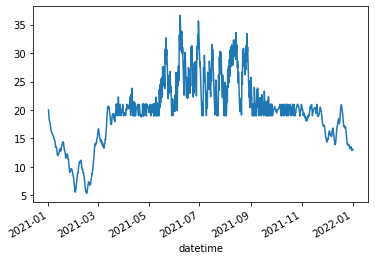

In [27]:
weather['tempcheck']=sol.y[2]
weather['tempcheck'].plot()

### Variable q_hvac Analysis

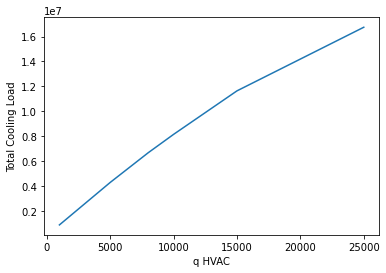

In [28]:
Input_q_hvac=[1000,5000,8000,10000,15000,25000]
q_hvac_cooling_tot=[870819.202910989,4279252.62903607,6667905.73483349,8143342.28810111,11639636.1737659,16750322.7737699 
]

plt.plot(Input_q_hvac,q_hvac_cooling_tot)
plt.xlabel('q HVAC')
plt.ylabel('Total Cooling Load')
plt.show()



## Model Analysis and Conclusion

Updating the model to include interior convection reveals several things about the system. First, it shows how unfeasible it is to use a geothermal cooling system to keep the temperature on the ceiling constant. By setting the fixed temperature to be in the middle of the room, the model not only becomes more accurate to realistic building design desires, it also drastically reduces the required cooling load. This is because interior convection adds a hysteresis affect which increases the time required to heat up the set point temperature, which means the cooling system requires less power to maintain temperature.

The second conclusion reached about this system is that simple steel and insulation roofs are extremely poor choises for climate controlled rooms. Even with 50 kWs of HVAC cooling, the temperature in the room still exceeded 21$^{\circ}$C consistently throughout the summer months, peaking at around 28$^{\circ}$C. The graph of Total Cooling Load versus q HVAC only reaches a stable point where increasing the HVAC power has negligible impact on the total cooling load when q HVAC is well over 100 kW, at which point the temperature still ocassionally exceeds 2$1^{\circ}$C. Reducing the net thermal conductivity of the roof should be able to reduce this point down to around 10-15 kW. Such a change would also increase the degree of the first conclusion, further demonstraighting how ineffectual balancing a cooling system off of ceiling temperature is. These results can be taken as a case study emphasizing the importance of proper building insulation. 

Despite the poor building insulation, this rough estimate still shows geothermal cooling to be a viable option with pump power, pipe length, and pipe cost not being prohibitively large. With a better insulated model building these costs would reduce even further. This supports the conclusion that low depth geothermal cooling would indeed be a viable means cooling buildings in Vermont over the summer.  

